## Step 1 Read in the data

HD5 has 1/17th the read and write time of csv, since the data size is on the order of 10 million points, these gains are worth while.

First we read in the data files as csv, convert them each to h5, and then combine them both as h5.

# Instructions
Set dataDir to the directory containing the glider files. If the h5 files already exist there, they wont be regenerated.

# If using colab set this true

In [9]:
using_colab = False

### Control binning size

In [10]:
numbins = 1e1

# Remember to modify to directory which contains ONLY the .csv raw data

In [29]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

if using_colab:
    # Mount Google Drive in Colab
    from google.colab import drive
    drive.mount('/content/drive')
    # Set your data directory to the correct folder in your Google Drive
    data_dir = '/content/drive/MyDrive/path/to/data'
else:
    # Set your local data directory path
    data_dir = '/home/jaiden/Final5P87/data'
file_count = sum(1 for entry in os.listdir(data_dir) 
                 if os.path.isfile(os.path.join(data_dir, entry)))
print("Number of files:", file_count)

Number of files: 14


/home/jaiden/Final5P87/data
['/home/jaiden/Final5P87/data/sambro_20210705_134_delayed_corrected_v4.csv', '/home/jaiden/Final5P87/data/scotia_20180720_87_delayed_corrected_v4.csv', '/home/jaiden/Final5P87/data/scotia_20190605_100_delayed_corrected_v4.csv', '/home/jaiden/Final5P87/data/cabot_20200717_114_delayed_corrected_v4.csv', '/home/jaiden/Final5P87/data/fundy_20230726_175_delayed_corrected_v4.csv', '/home/jaiden/Final5P87/data/scotia_20181113_95_delayed_corrected_v4.csv', '/home/jaiden/Final5P87/data/scotia_20220421_150_delayed_corrected_v4.csv', '/home/jaiden/Final5P87/data/cabot_20210706_135_delayed_corrected_v4.csv', '/home/jaiden/Final5P87/data/scotia_20210719_136_delayed_corrected_v4.csv', '/home/jaiden/Final5P87/data/cabot_20220603_155_delayed_corrected_v4.csv', '/home/jaiden/Final5P87/data/peggy_20230417_167_delayed_corrected_v4.csv', '/home/jaiden/Final5P87/data/shad_20230601_168_delayed_corrected_v4.csv', '/home/jaiden/Final5P87/data/peggy_20220421_151_delayed_corrected_v4

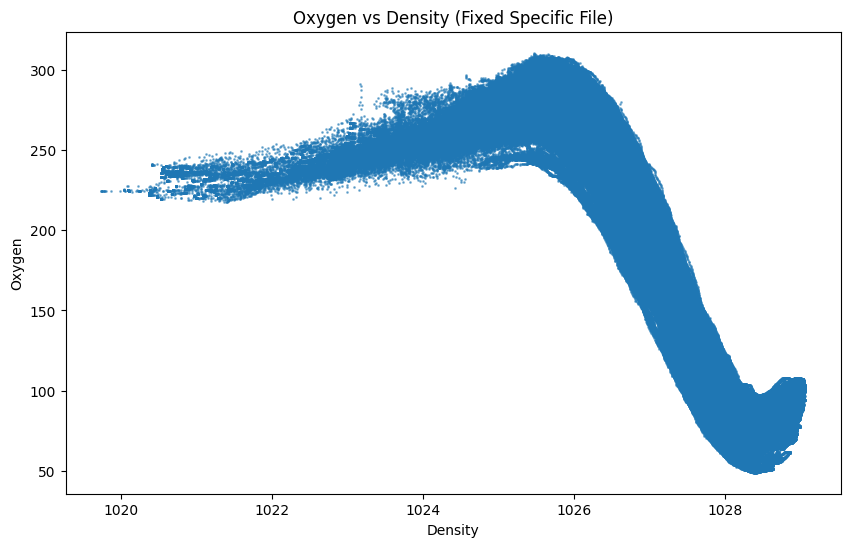


Combining the following HDF5 files:
/home/jaiden/Final5P87/data/cabot_20220603_155_delayed_corrected_v4.h5
/home/jaiden/Final5P87/data/shad_20230601_168_delayed_corrected_v4.h5
/home/jaiden/Final5P87/data/peggy_20220421_151_delayed_corrected_v4.h5
/home/jaiden/Final5P87/data/scotia_20190605_100_delayed_corrected_v4.h5
/home/jaiden/Final5P87/data/scotia_20220421_150_delayed_corrected_v4.h5
/home/jaiden/Final5P87/data/fundy_20230726_175_delayed_corrected_v4.h5
/home/jaiden/Final5P87/data/peggy_20230417_167_delayed_corrected_v4.h5
/home/jaiden/Final5P87/data/scotia_20181113_95_delayed_corrected_v4.h5
/home/jaiden/Final5P87/data/sambro_20210705_134_delayed_corrected_v4.h5
/home/jaiden/Final5P87/data/cabot_20200717_114_delayed_corrected_v4.h5
/home/jaiden/Final5P87/data/fixed_cabot_20210706_135_delayed_corrected_v4.h5
/home/jaiden/Final5P87/data/cabot_20220727_158_delayed_corrected_v4.h5
/home/jaiden/Final5P87/data/scotia_20210719_136_delayed_corrected_v4.h5
/home/jaiden/Final5P87/data/sco

In [30]:

print(data_dir)
# ---------------------------
# Step 1: Convert CSV files to HDF5 files
# ---------------------------

# Define data types and chunk size for CSV reading.
dtypes = {
    "longitude": "float32",
    "latitude": "float32",
    "depth": "float32",
    "time": "str",  # Keep as string if date parsing is not required immediately
    "salinity": "float32",
    "density": "float32",
    "temperature": "float32"
}
chunksize = 10**6

def regularize_chunk(chunk):
    """
    Rename columns (if needed), convert numeric columns to float32,
    and remove rows where oxygen is not positive.
    """
    col_mapping = {
        "sea_water_temperature": "temperature",
        "sea_water_practical_salinity": "salinity",
        "sea_water_density": "density",
        "micromoles_of_oxygen_per_unit_mass_in_sea_water": "oxygen"
    }
    chunk.rename(columns=col_mapping, inplace=True)
    for col in ["latitude", "longitude", "depth", "temperature", "salinity", "density", "oxygen"]:
        if col in chunk.columns:
            chunk[col] = pd.to_numeric(chunk[col], errors='coerce').astype("float32")
    if "oxygen" in chunk.columns:
        chunk = chunk[chunk["oxygen"] > 0]
    return chunk

csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
print(csv_files)

for csv_file in csv_files:
    if not csv_file.lower().endswith('.csv'):
        continue
    base_name = os.path.splitext(os.path.basename(csv_file))[0]
    hdf_file = os.path.join(data_dir, base_name + ".h5")
    if os.path.exists(hdf_file):
        print(f"Skipping conversion; {hdf_file} already exists.")
        continue
    print(f"Converting {csv_file} to {hdf_file}...")
    with pd.HDFStore(hdf_file, mode='w') as store:
        for i, chunk in enumerate(pd.read_csv(csv_file, dtype=dtypes, chunksize=chunksize, low_memory=False)):
            chunk = regularize_chunk(chunk)
            store.append('data', chunk, format='table', data_columns=True)
            print(f"  Processed chunk {i} for {csv_file}")
    print(f"Conversion complete for {csv_file}")

# ---------------------------
# Step 2: Clean the specific HDF5 file
# ---------------------------
specific_orig = os.path.join(data_dir, "cabot_20210706_135_delayed_corrected_v4.h5")
specific_fixed = os.path.join(data_dir, "fixed_cabot_20210706_135_delayed_corrected_v4.h5")
if os.path.exists(specific_orig):
    print(f"\nCleaning specific file: {specific_orig}")
    df_specific = pd.read_hdf(specific_orig, key='data')
    initial_count = len(df_specific)
    
    # Remove rows where density is between 1023.11 and 1023.13 (inclusive)
    df_specific_clean = df_specific[~((df_specific['density'] >= 1023.11) & (df_specific['density'] <= 1023.13))].copy()
    final_count = len(df_specific_clean)
    removed_count = initial_count - final_count
    print(f"Removed {removed_count} data points (from {initial_count} total rows) in the specific file.")
    
    # Save the cleaned data as a fixed version.
    df_specific_clean.to_hdf(specific_fixed, key='data', mode='w')
    print(f"Cleaned file saved as: {specific_fixed}")
    
    # Plot Oxygen vs. Density for the fixed file.
    plt.figure(figsize=(10, 6))
    plt.scatter(df_specific_clean['density'], df_specific_clean['oxygen'], s=1, alpha=0.5)
    plt.xlabel("Density")
    plt.ylabel("Oxygen")
    plt.title("Oxygen vs Density (Fixed Specific File)")
    plt.show()
else:
    print(f"Specific file {specific_orig} not found. Skipping cleaning step.")

# ---------------------------
# Step 3: Combine all HDF5 files into one
# ---------------------------
combined_hdf = os.path.join(data_dir, "glider_data.h5")
h5_files = glob.glob(os.path.join(data_dir, "*.h5"))

# If the fixed version exists, exclude the original specific file.
if os.path.exists(specific_fixed):
    h5_files = [f for f in h5_files if os.path.basename(f) != "cabot_20210706_135_delayed_corrected_v4.h5"]
    if specific_fixed not in h5_files:
        h5_files.append(specific_fixed)

print("\nCombining the following HDF5 files:")
for f in h5_files:
    print(f)

# Read each HDF5 file and combine the data.
df_list = []
for h5_file in h5_files:
    try:
        df_temp = pd.read_hdf(h5_file, key='data')
        df_list.append(df_temp)
        print(f"Loaded {len(df_temp)} rows from {h5_file}")
    except Exception as e:
        print(f"Error reading {h5_file}: {e}")

if df_list:
    df_combined = pd.concat(df_list, ignore_index=True)
    df_combined.to_hdf(combined_hdf, key='data', mode='w')
    print(f"\nCombined HDF5 file saved to: {combined_hdf}")
    print("Head of combined data:")
    print(df_combined.head())
else:
    print("No data to combine.")


## Step 2 Cluster data

In [31]:
!pip install ripser
!pip install persim
!pip install networkx
!pip install scikit-learn
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 834.5/834.5 KB 8.8 MB/s eta 0:00:008.8 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 KB 15.1 MB/s eta 0:00:00
  Using cached Cython-3.0.12-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 KB 31.8 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18120 sha256=450854fab9e05738bbd764cc0d325800a886fb0d6297efbbe093fcec1f7db776
  Stored in directory: /home/jaiden/.cache/pip/wheels/ef/0f/3b/0f931844eecc34addd90e72d54cd39c08b7066c5f25c00b9a4
Successfully built hopcroftkarp
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-p

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Initial dataset size: 10356849
Number of sample points used for homology: 1000


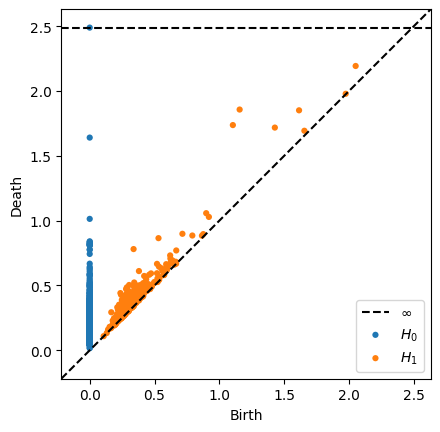

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import pdist, squareform
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

def split_large_component(component_indices, points, max_size):
    """
    Given a set of indices for a large connected component,
    split it into smaller clusters so that each resulting cluster has at most max_size points.
    """
    component_indices = np.array(list(component_indices))
    num_points = len(component_indices)
    n_clusters = int(np.ceil(num_points / max_size))
    component_points = points[component_indices]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    sub_labels = kmeans.fit_predict(component_points)
    new_clusters = []
    for cl in np.unique(sub_labels):
        indices = component_indices[sub_labels == cl]
        new_clusters.append(set(indices))
    return new_clusters

sample_file = os.path.join(data_dir, 'glider_data.h5')
df = pd.read_hdf(sample_file)
print("Initial dataset size:", df.shape[0])

from sklearn.preprocessing import StandardScaler

# For the sample, we use 5000 rows
df_sample = df.sample(n=1000, random_state=42)
df_sample = df_sample.dropna()
df_sample = df_sample.drop(columns=['time'], errors='ignore')

# Remove the oxygen column because it is our dependent variable.
if 'oxygen' in df_sample.columns:
    df_sample = df_sample.drop(columns=['oxygen'])

# Select only the features for topology: latitude, longitude, and depth.
# (Adjust the order if desired; here we assume columns are named exactly.)
required_features = ['latitude', 'longitude', 'depth', 'salinity', 'density', 'temperature']
if not all(col in df_sample.columns for col in required_features):
    raise ValueError(f"One or more required columns {required_features} not found in the sample data.")

df_features = df_sample[required_features]
scaler = StandardScaler()
points = scaler.fit_transform(df_features.values)
n_points = points.shape[0]
print("Number of sample points used for homology:", n_points)

result = ripser(points, maxdim=1)
diagrams = result['dgms']
plot_diagrams(diagrams, show=True)

In [32]:
threshold_input = input("The persistence diagram is displayed.\nEnter connectivity threshold (e.g., 15): ")
try:
    threshold = float(threshold_input)
except ValueError:
    print("Invalid input. Using default threshold of 15")
    threshold = 15.0
print("Chosen connectivity threshold (epsilon):", threshold)

The persistence diagram is displayed.
Enter connectivity threshold (e.g., 15):  15


Chosen connectivity threshold (epsilon): 15.0


In [33]:
dist_matrix = squareform(pdist(points))
G = nx.Graph()
G.add_nodes_from(range(n_points))
for i in range(n_points):
    for j in range(i + 1, n_points):
        if dist_matrix[i, j] <= threshold:
            G.add_edge(i, j)

components = list(nx.connected_components(G))
print("Number of connected components before splitting:", len(components))

max_size = len(df_sample) / 15  # Adjust this factor as needed.
new_components = []
for comp in components:
    if len(comp) > max_size:
        split_comps = split_large_component(comp, points, max_size)
        new_components.extend(split_comps)
    else:
        new_components.append(comp)
print("Number of components after splitting:", len(new_components))

labels = np.empty(n_points, dtype=int)
for label, comp in enumerate(new_components):
    for idx in comp:
        labels[idx] = label

# Merge clusters that are very small relative to the median cluster size.
cluster_sizes = np.array([len(comp) for comp in new_components])
median_size = np.median(cluster_sizes)
min_size_threshold = 0.5 * median_size  # Merge clusters smaller than 50% of median size.
print("Median cluster size:", median_size)
print("Merging clusters smaller than:", min_size_threshold)

num_clusters = len(new_components)
# Compute centroids for each cluster (using the sample points)
centroids = np.zeros((num_clusters, points.shape[1]))
for i, comp in enumerate(new_components):
    comp_indices = list(comp)
    centroids[i] = np.mean(points[comp_indices], axis=0)

# For each cluster that is too small, merge it into the nearest cluster (by centroid distance)
for i in range(num_clusters):
    if cluster_sizes[i] < min_size_threshold:
        distances = np.linalg.norm(centroids[i] - centroids, axis=1)
        distances[i] = np.inf  # ignore self-distance
        nearest = np.argmin(distances)
        print(f"Merging small cluster {i} (size {cluster_sizes[i]}) into cluster {nearest} (size {cluster_sizes[nearest]})")
        labels[labels == i] = nearest


# Load and preprocess the full dataset.
df_full = pd.read_hdf(sample_file)
print("Full dataset shape before cleaning:", df_full.shape)
df_full = df_full.dropna()
df_full = df_full.drop(columns=['time'], errors='ignore')
print("Full dataset shape after cleaning:", df_full.shape)

# For cluster assignment, use only latitude, longitude, and depth features.
if not all(col in df_full.columns for col in required_features):
    raise ValueError(f"One or more required columns {required_features} not found in the full dataset.")

df_full_features = df_full[required_features]
full_points = scaler.transform(df_full_features.values)

# Build a nearest neighbor model using the sample points (with topology clusters)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(points)
distances, indices = nbrs.kneighbors(full_points)
distances = distances.flatten()
indices = indices.flatten()

# For each full dataset point, if its nearest sample point is within the threshold,
# assign the corresponding (merged) cluster label; otherwise, mark as noise (-1).
full_labels = np.where(distances <= threshold, labels[indices], -1)
df_full['component_label'] = full_labels

print("Full dataset cluster assignment complete.")
print("Cluster label counts:", dict(zip(*np.unique(full_labels, return_counts=True))))


# Here we use latitude, longitude, and depth for a 3D plot.
df_full_sample = df_full.sample(n=4000, random_state=42)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df_full_sample['longitude'], df_full_sample['latitude'], df_full_sample['depth'],
                c=df_full_sample['component_label'], cmap='tab20', s=5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')
plt.title("3D Point Cloud of Full Dataset by Component")
plt.colorbar(sc, label='Component Label')
plt.show()


unique_clusters = np.unique(full_labels)
unique_clusters = unique_clusters[1:]
count = 0

# Do not include outlier (-1)
for cluster in unique_clusters:
    subset = df_full[df_full['component_label'] == cluster]
    filename = f"component_{count}.h5"
    subset.to_hdf(filename, key='df', mode='w')
    print(f"Saved cluster {cluster} with {len(subset)} points to {filename}")
    destination = f"/content/drive/MyDrive/Glider data/{filename}"
    !mv "/content/{filename}" "{destination}"
    count += 1

NameError: name 'squareform' is not defined

## Step 3 Bin data

In [ ]:
import numpy as np
import pandas as pd
!pip install tables

df = pd.read_hdf('/content/drive/MyDrive/Glider data/component_0.h5')

# For demonstration, let's assume you also have a 'depth' column
# If depth is not available, you'll need to include it or compute it from other information
if 'depth' not in df.columns:
    raise ValueError("The DataFrame must contain a 'depth' column for voxel binning.")

# Define the number of bins for each dimension (adjust as needed)

num_lon_bins = numbins
num_lat_bins = numbins
num_depth_bins = numbins

# Compute bin edges using np.linspace based on the min and max of each variable
lon_bins = np.linspace(df['longitude'].min(), df['longitude'].max(), num_lon_bins + 1)
lat_bins = np.linspace(df['latitude'].min(), df['latitude'].max(), num_lat_bins + 1)
depth_bins = np.linspace(df['depth'].min(), df['depth'].max(), num_depth_bins + 1)

# Create new columns that assign each row to a bin index (0-based)
df['lon_bin'] = pd.cut(df['longitude'], bins=lon_bins, labels=False, include_lowest=True)
df['lat_bin'] = pd.cut(df['latitude'], bins=lat_bins, labels=False, include_lowest=True)
df['depth_bin'] = pd.cut(df['depth'], bins=depth_bins, labels=False, include_lowest=True)

# Create a voxel identifier as a tuple of (lon_bin, lat_bin, depth_bin)
df['voxel'] = list(zip(df['lon_bin'], df['lat_bin'], df['depth_bin']))

# Group the data by voxel and compute aggregate statistics, e.g., mean oxygen value
voxel_grouped = df.groupby('voxel').agg({
    'oxygen': 'mean',
    'longitude': 'mean',
    'latitude': 'mean',
    'depth': 'mean'
}).reset_index()

print("Binned Data (first few voxels):")
print(voxel_grouped.head())



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import os
import shutil

# Assuming you have 'voxel_grouped' DataFrame from the previous binning code

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot: x=longitude, y=latitude, z=depth, colored by mean oxygen
sc = ax.scatter(voxel_grouped['longitude'], voxel_grouped['latitude'],
                voxel_grouped['depth'], c=voxel_grouped['oxygen'], cmap='viridis', s=50)

# Add color bar to indicate oxygen levels
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Mean Oxygen')

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth")
ax.set_title("3D Voxels with Mean Oxygen")

# Optionally, if depth is measured as a positive value going downward, you might want to invert the z-axis
ax.invert_zaxis()

plt.show()
voxel_grouped.shape


def bin_glider_data(input_file, dim_bins = 10):

    # Ensure your dataset has a "depth" column along with "longitude" and "latitude"
    # If not, you'll need to add it before running the following code.

    # Example: Load your data (adjust the path as needed)
    #from google.colab import drive
    #drive.mount('/content/drive')
    df = pd.read_hdf(input_file)


    num_lon_bins = dim_bins * 1
    num_lat_bins = dim_bins * 1
    num_depth_bins = dim_bins * 1

    # For demonstration, let's assume you also have a 'depth' column
    # If depth is not available, you'll need to include it or compute it from other information
    if 'depth' not in df.columns:
        raise ValueError("The DataFrame must contain a 'depth' column for voxel binning.")

    # Compute bin edges using np.linspace based on the min and max of each variable
    lon_bins = np.linspace(df['longitude'].min(), df['longitude'].max(), num_lon_bins + 1)
    lat_bins = np.linspace(df['latitude'].min(), df['latitude'].max(), num_lat_bins + 1)
    depth_bins = np.linspace(df['depth'].min(), df['depth'].max(), num_depth_bins + 1)

    # Create new columns that assign each row to a bin index (0-based)
    df['lon_bin'] = pd.cut(df['longitude'], bins=lon_bins, labels=False, include_lowest=True)
    df['lat_bin'] = pd.cut(df['latitude'], bins=lat_bins, labels=False, include_lowest=True)
    df['depth_bin'] = pd.cut(df['depth'], bins=depth_bins, labels=False, include_lowest=True)

    # Create a voxel identifier as a tuple of (lon_bin, lat_bin, depth_bin)
    df['voxel'] = list(zip(df['lon_bin'], df['lat_bin'], df['depth_bin']))

    # Group the data by voxel and compute aggregate statistics, e.g., mean oxygen value
    voxel_grouped = df.groupby('voxel').agg({
        'oxygen': 'mean',
        'longitude': 'mean',
        'latitude': 'mean',
        'depth': 'mean'
    }).reset_index()

    print("Binned Data (first few voxels):")
    print(voxel_grouped.head())

    df = pd.read_hdf(input_file)

    # For demonstration, let's assume you also have a 'depth' column
    # If depth is not available, you'll need to include it or compute it from other information
    if 'depth' not in df.columns:
        raise ValueError("The DataFrame must contain a 'depth' column for voxel binning.")

    # Compute bin edges using np.linspace based on the min and max of each variable
    lon_bins = np.linspace(df['longitude'].min(), df['longitude'].max(), num_lon_bins + 1)
    lat_bins = np.linspace(df['latitude'].min(), df['latitude'].max(), num_lat_bins + 1)
    depth_bins = np.linspace(df['depth'].min(), df['depth'].max(), num_depth_bins + 1)

    # Create new columns that assign each row to a bin index (0-based)
    df['lon_bin'] = pd.cut(df['longitude'], bins=lon_bins, labels=False, include_lowest=True)
    df['lat_bin'] = pd.cut(df['latitude'], bins=lat_bins, labels=False, include_lowest=True)
    df['depth_bin'] = pd.cut(df['depth'], bins=depth_bins, labels=False, include_lowest=True)

    # Create a voxel identifier as a tuple of (lon_bin, lat_bin, depth_bin)
    df['voxel'] = list(zip(df['lon_bin'], df['lat_bin'], df['depth_bin']))

    # Group the data by voxel and compute aggregate statistics, e.g., mean oxygen value
    voxel_grouped = df.groupby('voxel').agg({
        'oxygen': 'mean',
        'longitude': 'mean',
        'latitude': 'mean',
        'depth': 'mean'
    }).reset_index()


    # Generate output filename
    num_voxels = voxel_grouped.shape[0]
    base_name = os.path.splitext(os.path.basename(input_file))[0]
    output_file = f"{base_name}_binned_{num_voxels}.h5"

    # Save the processed data
    voxel_grouped.to_hdf(output_file, key='data', mode='w')

    print(f"Processed data saved as: {output_file} with {num_voxels} data points")
    return output_file


def process_multiple_files(file_paths, output_directory, dim_bins):
    for input_file in file_paths:

        # Run the binning function for each file
        binned_file = bin_glider_data(input_file, dim_bins)

        # Correct the directory where the file should be saved
        final_binned_file = os.path.join(output_directory, os.path.basename(binned_file))

        # Rename or move the file to the correct directory on Drive
        shutil.move(binned_file, final_binned_file)

        # Print the final saved path
        print(f"Binned data saved as: {final_binned_file}")

        # Check if the file exists at the given path
        if os.path.exists(final_binned_file):
            print(f"The file exists at: {final_binned_file}")
        else:
            print(f"File not found at: {final_binned_file}")

# Generate the list of input files for components 0 to 14
input_files = [f"/content/drive/MyDrive/Glider data/component_{i}.h5" for i in range(14)]


# Generate folder if it does not exist yet
folder_path = f"/content/drive/My Drive/Glider data/dim_bins{numbins}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder created at: {folder_path}")
else:
    print(f"Folder already exists: {folder_path}")

# Directory where binned files will be saved
output_directory = f"/content/drive/MyDrive/Glider data/dim_bins{numbins}"

# Call the function to process multiple files
process_multiple_files(input_files, output_directory, numbins)
